In [1]:
import torch
import pandas
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt


In [2]:
d_x , d_y = (5,9)

normalize_tensor_sample = np.array([[1] + [640,640, 480, 480] + [3.14 for _ in range(d_y - 2)] + [100, 100] ])

def read_and_generate_data(data):
    fp = pandas.read_csv(data, delimiter=";")
    ts = np.array(fp.values)
    minTime = float(ts[0][0])
    timeScale = float(ts[-1][0])-minTime
    ts[:, 0]  = (ts[:, 0] - minTime) / timeScale
    ts[:] = ts[:]/normalize_tensor_sample
    return ts

def generate_samples(ts):
    random_rows = ts[np.random.choice(ts.shape[0], size=4, replace=False)]
    
    random_rows = np.array(random_rows)
    
    tensor_1 = torch.tensor(random_rows[:3], dtype=torch.double) 
    tensor_2 = torch.tensor([random_rows[3][:d_x]], dtype=torch.double) 
    tensor_3 = torch.tensor([[random_rows[3][d_x:]]], dtype=torch.double) 
    
     
    return tensor_1, tensor_2, tensor_3

def log_prob_loss(output, target):
    #print(f"Output : {output} target: {target}")
    mean, sigma = output.chunk(2, dim = -1)
    #print(f"Output: {output}, Target: {target}, Mean: {mean}, Sigma: {sigma}")
    sigma = nn.functional.softplus(sigma)
    dist = torch.distributions.Independent(torch.distributions.Normal(loc=mean, scale=sigma), 1)
    return -torch.mean(dist.log_prob(target))

class CNMP(nn.Module):
    def __init__(self):
        super(CNMP, self).__init__()
        
        # Encoder takes observations which are (X,Y) tuples and produces latent representations for each of them
        self.encoder = nn.Sequential(
        nn.Linear(d_x+d_y,128),nn.ReLU(),
        nn.Linear(128,128),nn.ReLU(),
        nn.Linear(128,128)
        )
        
        #Decoder takes the (r_mean, target_t) tuple and produces mean and std values for each dimension of the output
        self.decoder = nn.Sequential(
        nn.Linear(128+d_x,128),nn.ReLU(),
        nn.Linear(128,128),nn.ReLU(),
        nn.Linear(128,2*d_y)
    )

    def forward(self,observations,target_t):
        r = self.encoder(observations) # Generating observations
        r_mean = torch.mean(r,dim=0) # Taking mean and generating the general representation
        r_mean = r_mean.repeat(target_t.shape[0],1) # Duplicating general representation for every target_t
        concat = torch.cat((r_mean,target_t),dim=-1) # Concatenating each target_t with general representation
        output = self.decoder(concat) # Producing mean and std values for each target_t
        return output

In [ ]:
model = CNMP().double()

#model.load_state_dict(torch.load("")) # Uncomment for extra training

In [ ]:
model.train()
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

all_data = [f"./training_data/Pour_R{i}/robotdata.csv" for i in range(1,16)]

lossLst = []

ts_data = []

for d in all_data:
    ts_data.append(read_and_generate_data(d))

for i in range(1_000_000):
    rand_data_ind = np.random.randint(0, len(ts_data))

    samples, target_x, target_y = generate_samples(ts_data[rand_data_ind])
    optimizer.zero_grad()
    output = model(samples[:3], target_x)
    loss = log_prob_loss(output, target_y)
    lossLst.append(loss.item())
    loss.backward()
    optimizer.step()

    if (i % 100000 == 0):
        print(f"Epoch: {i} done")
    



In [6]:
model.eval()
torch.save(model.state_dict(), "Pour_Right_New.pth")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


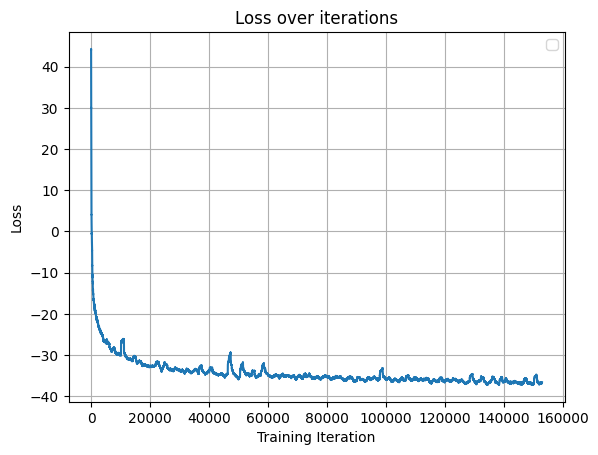

In [5]:
loss_data = np.array(lossLst)

# Smoothing window size
window_size = 1000


smoothed_loss = np.convolve(loss_data, np.ones(window_size)/window_size, mode='valid')
lossX = [i for i in range(len(smoothed_loss))]

plt.plot(lossX, smoothed_loss)
plt.title("Loss over iterations")
plt.xlabel("Training Iteration")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()